# Анализ вакансий
**Часть 6**
## Кластеризация и уточнение требований требований

# 1. Служебный код
## 1.1. Импорт
### 1.1.1. Импорт библиотек

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
pd.options.plotting.backend = "plotly" #interactive plots will be useful in this context
import plotly.express as px
import seaborn as sns
import numpy as np
from sentence_transformers import SentenceTransformer, util
import torch
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, classification_report, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from datetime import datetime
from importlib import reload
import warnings

### 1.1.2. Импорт модулей

In [28]:
import config
reload(config)
from config import settings

import scripts.utils.files as files
reload(files)

import scripts.model_scripts.cluster_utils as cu
reload(cu)

import scripts.model_scripts.text_process as proc
reload(proc)

from scripts.data_scripts import clear_text as cl
reload(cl)

<module 'scripts.data_scripts.clear_text' from '/mnt/data/projects/active/urfu/vkr/scripts/data_scripts/clear_text.py'>

## 1.2. Настройка параметров

In [3]:
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 20)
pd.set_option("display.precision",6)
sns.set_style("ticks",{'axes.grid' : True})
warnings.simplefilter("ignore")

#Для корректного отображения графиков в ноутбуках используется команда %matplotlib inline
%matplotlib inline
# для корректного отображения графиков на тёмном фоне
plt.style.use('default')
RANDOM_STATE = 123

In [29]:
MODEL_SUBDIR = settings.get_fresh('BLOCK_MODELING_SUBDIR')
PROCESSED_SUBDIR = settings.get_fresh('PROCESSED_LOCAL_SUBDIR')
READY_DATA_LOCAL_SUBDIR = settings.get_fresh('READY_DATA_LOCAL_SUBDIR')
NLTK_DIR  = settings.get_fresh('NLTK_DIR')
FILENAME_EMB_SUFFIX = settings.get_fresh('FILENAME_EMB_SUFFIX')
FILENAME_UMAP_SUFFIX = settings.get_fresh('FILENAME_UMAP_SUFFIX')
FILENAME_DBSCAN_SUFFIX = settings.get_fresh('FILENAME_DBSCAN_SUFFIX')
FILENAME_ALL_KEYWORD = settings.get_fresh('FILENAME_ALL_KEYWORD')
FILENAME_CLUSTER_KEYWORDS = settings.get_fresh('FILENAME_CLUSTER_KEYWORDS')
FILENAME_CLUSTER_DATA = settings.get_fresh('FILENAME_CLUSTER_DATA')

In [4]:
MODEL1_NAME='paraphrase_minilm_l12'
MODEL2_NAME= 'distiluse_cased_v2'
MODEL3_NAME='paraphrase_mpnet_v2'
MODEL4_NAME='stsb_xlm_r'

MODELS = {MODEL1_NAME:
              'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2',
       MODEL2_NAME:
             'sentence-transformers/distiluse-base-multilingual-cased-v2',
         MODEL3_NAME:
              'sentence-transformers/paraphrase-multilingual-mpnet-base-v2',
         MODEL4_NAME:
              'sentence-transformers/stsb-xlm-r-multilingual'}

N_COMPONENTS=[2, 3, 4]

In [5]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())

True
1
0


In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

# 2. Загрузка данных и общее описание набора данных
## 2.1. Загрузка данных

In [9]:
requirements_filename = settings.get_fresh('FILENAME_REQUIREMENTS_TOKENIZED_CLEANED')
requirements_dict=files.load_data_dump(requirements_filename, MODEL_SUBDIR)
df = pd.DataFrame.from_dict(requirements_dict, "index")
df.reset_index(inplace=True)
df.rename(columns={'index':'code'}, inplace=True)

In [10]:
embeddings={}
for m_key in MODELS:
    filename = f'{m_key}_{FILENAME_EMB_SUFFIX}_cl'
    embeddings[m_key]=files.load_data_dump(filename, MODEL_SUBDIR)

umap_embeddings={}
for m_key in MODELS:
    n_embeddings={}
    for n in N_COMPONENTS:
        filename = f'{m_key}_{n}_{FILENAME_UMAP_SUFFIX}_cl'
        n_embeddings[n]=files.load_data_dump(filename, MODEL_SUBDIR)
    umap_embeddings[m_key]=n_embeddings

## 2.2. Информация о наборе данных

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600302 entries, 0 to 600301
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   code       600302 non-null  object
 1   count      600302 non-null  int64 
 2   canonical  600302 non-null  object
 3   unigrams   600302 non-null  object
 4   bigrams    600302 non-null  object
 5   trigrams   600302 non-null  object
dtypes: int64(1), object(5)
memory usage: 27.5+ MB


In [8]:
df.head()

code  count  \
0             опыт_взаимодействие_команда_разработка     42   
1  опыт_работа_реляционный_бд_sql_формирование_по...      1   
2  опыт_работа_функциональный_требование_формиров...      1   
3  опыт_подготовка_проектный_документация_техниче...      1   
4                            операционный_инструкция     15   

                                           canonical  \
0          опыт взаимодействия с командой разработки   
1  опыт работы с реляционными БД SQL для формиров...   
2  опыт работы с функциональными требования для ф...   
3  опыт подготовки проектной документации техниче...   
4                            операционные инструкции   

                                            unigrams  \
0        [опыт, взаимодействие, команда, разработка]   
1  [опыт, работа, реляционный, бд, sql, формирова...   
2  [опыт, работа, функциональный, требование, фор...   
3  [опыт, подготовка, проектный, документация, те...   
4                         [операционный, инструкция]   

                                             bigrams  \
0  [(опыт, взаимодействие), (взаимодействие, кома...   
1  [(опыт, работа), (работа, реляционный), (реляц...   
2  [(опыт, работа), (работа, функциональный), (фу...   
3  [(опыт, подготовка), (подготовка, проектный), ...   
4                       [(операционный, инструкция)]   

                                            trigrams  
0  [(опыт, взаимодействие, команда), (взаимодейст...  
1  [(опыт, работа, реляционный), (работа, реляцио...  
2  [(опыт, работа, функциональный), (работа, функ...  
3  [(опыт, подготовка, проектный), (подготовка, п...  
4                                                 []

In [9]:
dfk=df.sample(n=100000)
filename = 'df.sample'
files.save_dataframe(dfk, filename, MODEL_SUBDIR)

'/mnt/data/projects/active/urfu/vkr/data/block_modeling/df.sample.csv.gz'

In [8]:
filename = 'df.sample'
dfk=files.load_file(filename, MODEL_SUBDIR,with_dates=False)

# 3. Кластеризация требований

## 3.1. Оценка качества кластеризации с помощью индекса силуэта
Без размеченного набора данных из-за отсутствия достоверной информации трудно оценить модель, полученную на основе извлеченных требований. Это делает выбор и настройку модели сложной задачей. В таком случае метрики приходится вычислять на основе самой модели.
Наилучшим кандидатом в качестве такой метрики является индекс силуэта (Silhouette score). Анализ силуэта относится к методу интерпретации и проверки согласованности внутри кластеров данных. Значение силуэта является мерой того, насколько объект похож на свой собственный кластер (сплоченность) по сравнению с другими кластерами (разделение). Его можно использовать для изучения расстояния разделения между полученными кластерами. График силуэта отображает степень близости каждой точки в одном кластере к точкам в соседних кластерах и, таким образом, предоставляет способ визуальной оценки таких параметров, как количество кластеров.
Метод проверки силуэта вычисляет индекс силуэта для каждой выборки, средний индекс силуэта для каждого кластера и общий средний индекс силуэта для набора данных.
- Если значение индекса силуэта велико, объект хорошо соответствует своему собственному кластеру и плохо соответствует соседним кластерам. Если значение силуэта близко к 1, выборка хорошо кластеризована.
- Если значение силуэта примерно равно 0, выборка может быть назначена другому ближайшему к нему кластеру, и выборка находится одинаково далеко от обоих кластеров. Это означает, что она указывает на перекрывающиеся кластеры.
- Если значение силуэта близко к -1, образец неправильно классифицирован и просто помещен где-то между кластерами.

Далее индекс силуэта будет вычислен для каждой из моделей векторизации предложений с целью выбрать наиболее подходящий метод векторизации и оптимальное число кластеров..

Для оценки силуэта будут использоваться данные с уменьшенной размерностью эмбедингов. Для итоговой кластеризации будут использоваться эмбединги оригинальной размерности.
Также для построения модели кластеризации будет использоваться не весь массив данных, а только его часть, выбранная случайно.

Определение индексов элементов, которые попадут в выборку для кластеризации

In [11]:
indexes=np.random.choice(len(umap_embeddings[MODEL1_NAME][2]),100000,replace=False)

Вычисление индекса силуэта для K=[20,900] (К - количество кластеров)

In [25]:
print(datetime.now())
range_n_clusters = range(420,900,20)
silhouettes={}

for m_key in MODELS:
    x_values=[]
    silhouette_avg_n_clusters = []
    umaps=umap_embeddings[m_key][2][indexes]
    for n_cluster in range_n_clusters:
        print("k = "+str(n_cluster)+" "+  str(datetime.now()))
        x_values.append(n_cluster)
        kmeans2 = KMeans(init='k-means++',n_clusters=n_cluster, random_state=18).fit(umaps)
        labels = kmeans2.labels_
        silhouette_avg = silhouette_score(umaps, labels, metric = 'euclidean')
        silhouette_avg_n_clusters.append(silhouette_avg)

    silhouettes[m_key]={'x_values': x_values, 'silhouette_avg':silhouette_avg_n_clusters }

    print('done with model '+str(datetime.now()))

2024-05-19 15:15:26.793301
k = 420 2024-05-19 15:15:26.800126
k = 440 2024-05-19 15:18:03.673258
k = 460 2024-05-19 15:20:41.640933
k = 480 2024-05-19 15:23:21.104615
k = 500 2024-05-19 15:26:02.621498
k = 520 2024-05-19 15:28:43.289177
k = 540 2024-05-19 15:31:28.051809
k = 560 2024-05-19 15:34:13.617243
k = 580 2024-05-19 15:37:02.204703
k = 600 2024-05-19 15:39:53.085817
k = 620 2024-05-19 15:42:42.562787
k = 640 2024-05-19 15:45:35.311200
k = 660 2024-05-19 15:48:26.702538
k = 680 2024-05-19 15:51:19.197726
k = 700 2024-05-19 15:54:12.928148
k = 720 2024-05-19 15:57:12.315392
k = 740 2024-05-19 16:00:14.231108
k = 760 2024-05-19 16:03:21.063558
k = 780 2024-05-19 16:06:25.652398
k = 800 2024-05-19 16:09:35.995808
k = 820 2024-05-19 16:12:56.576146
k = 840 2024-05-19 16:16:07.677504
k = 860 2024-05-19 16:19:18.207416
k = 880 2024-05-19 16:22:34.558433
done with model 2024-05-19 16:25:47.286939
k = 420 2024-05-19 16:25:47.289836
k = 440 2024-05-19 16:28:44.414784
k = 460 2024-05-19 1

In [27]:
from datetime import datetime
print(datetime.now())

fig = px.line()
fig.update_layout(
    title="Model Selection and Optimizing the Number of Clusters",
    xaxis_title="Number of clusters K",
    yaxis_title="Silhouette Score", 
)
for m_key in MODELS:
    fig.add_scatter(x= silhouettes[m_key]['x_values'],y= silhouettes[m_key]['silhouette_avg'],mode='lines', name=MODELS[m_key])

fig.show()

2024-05-19 20:08:30.725585


Анализ графика показывает, что с увеличением числа кластеров индекс силуэта растет, и качество кластеризации также возрастает.
Лучше всего показала себя модель №1, немного уступает ей модель №3. Но в модели №1 используется вектор длиной 384, а в модели №3 - 768. Поэтому выбор очевиден в пользу модели №1 - 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'.
Оптимальное количество кластеров - К=
 The optimal number of clusters is between K=38.
Because of optimization after analyzing the frequency of cluster precence in each job posting, a lower number for K shows to be beneficial. The local optimum at K=31 was selected as most appropriate.

In [12]:
selected_model=MODEL1_NAME

In [36]:
print(datetime.now())
range_n_clusters = range(900,2000,50)
silhouettes1={}

for n in [2, 3, 4]:
    x_values=[]
    silhouette_avg_n_clusters = []
    umaps=umap_embeddings[selected_model][n][indexes]
    for n_cluster in range_n_clusters:
        print("k = "+str(n_cluster)+" "+  str(datetime.now()))
        x_values.append(n_cluster)
        kmeans2 = KMeans(init='k-means++',n_clusters=n_cluster, random_state=18).fit(umaps)
        labels = kmeans2.labels_
        silhouette_avg = silhouette_score(umaps, labels, metric = 'euclidean')
        silhouette_avg_n_clusters.append(silhouette_avg)

    silhouettes1[n]={'x_values': x_values, 'silhouette_avg':silhouette_avg_n_clusters }

    print('done with model '+str(datetime.now()))

2024-05-19 23:41:58.455993
k = 900 2024-05-19 23:41:58.462352
k = 950 2024-05-19 23:45:11.423085
k = 1000 2024-05-19 23:48:24.710095
k = 1050 2024-05-19 23:51:37.955176
k = 1100 2024-05-19 23:54:55.529911
k = 1150 2024-05-19 23:58:19.839859
k = 1200 2024-05-20 00:01:47.683296
k = 1250 2024-05-20 00:05:20.648941
k = 1300 2024-05-20 00:08:57.263836
k = 1350 2024-05-20 00:12:35.708117
k = 1400 2024-05-20 00:16:16.323617
k = 1450 2024-05-20 00:20:03.022377
k = 1500 2024-05-20 00:23:52.066820
k = 1550 2024-05-20 00:27:43.184713
k = 1600 2024-05-20 00:31:33.558105
k = 1650 2024-05-20 00:35:28.015329
k = 1700 2024-05-20 00:39:24.272940
k = 1750 2024-05-20 00:43:26.792005
k = 1800 2024-05-20 00:47:34.024784
k = 1850 2024-05-20 00:51:40.102509
k = 1900 2024-05-20 00:55:49.555230
k = 1950 2024-05-20 01:00:05.018861
done with model 2024-05-20 01:04:24.337796
k = 900 2024-05-20 01:04:24.340742
k = 950 2024-05-20 01:07:38.913530
k = 1000 2024-05-20 01:10:54.271789
k = 1050 2024-05-20 01:14:11.38127

In [77]:
from datetime import datetime
print(datetime.now())

fig = px.line()
fig.update_layout(
    title="Model Selection and Optimizing the Number of Clusters",
    xaxis_title="Number of clusters K",
    yaxis_title="Silhouette Score",
)
for n in [ 2, 3, 4]:
    fig.add_scatter(x= silhouettes1[n]['x_values'],y= silhouettes1[n]['silhouette_avg'],mode='lines', name=f'n={n}')

fig.show()

2024-05-20 05:38:09.828934


In [76]:
silhouettes2={'bymodel':silhouettes, 'bykclusterov':silhouettes1}
filename = 'silhouettes_all'
files.save_data_dump(silhouettes2, filename, MODEL_SUBDIR)

'/mnt/data/projects/active/urfu/vkr/data/block_modeling/silhouettes_all.dmp'

Итоговая модель кластеризации требований:

In [13]:
K_cluster=1200
selected_n=2
umaps=umap_embeddings[selected_model][selected_n]

In [ ]:
kmeans_model = KMeans(init='k-means++',n_clusters=K_cluster, random_state=18).fit(umaps)

In [ ]:
filename=settings.get_fresh('FILENAME_REQUIREMENTS_CLUSTERING_MODEL')
processed_data_file_path = files.save_model(kmeans_model, filename)
print(processed_data_file_path)

In [15]:
filename=settings.get_fresh('FILENAME_REQUIREMENTS_CLUSTERING_MODEL')
kmeans_model = files.load_model(filename)

In [16]:
df['cluster']=kmeans_model.labels_

In [17]:
selected_n=2

In [18]:
#Creating columns in df to visualize results of umap
df[f'{selected_model}_1']= [i[0] for i in umaps]
df[f'{selected_model}_2']= [i[1] for i in umaps]

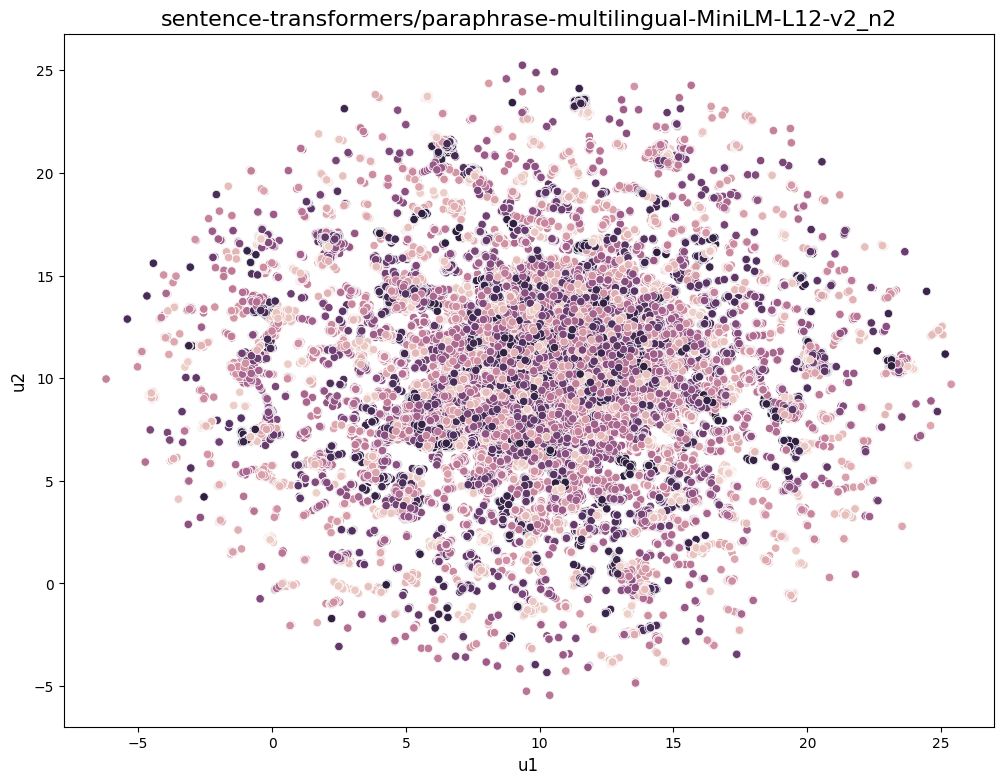

In [111]:
plt.figure(figsize=(12, 9))
x=df[f'{selected_model}_1']
y=df[f'{selected_model}_2']
z=df['cluster']
sns.scatterplot(x=x, y= y, hue=z,  legend=None) #.set_title(f'{MODELS[mkey]}_n{nn}', fontsize=16)
plt.title(f'{MODELS[selected_model]}_n{selected_n}', fontsize=16)
plt.ylabel('u2', fontsize=12)
plt.xlabel('u1', fontsize=12)
plt.show()

# 4. Классификация

In [19]:
df['norm_content']=df['unigrams'].apply(proc.join_unigrams)

In [23]:
print(datetime.now())
requirements = df.norm_content.tolist()
norm_embeddings={}

for m_key in MODELS:
   model = SentenceTransformer(MODELS[m_key])
   print('encoding '+m_key + str(datetime.now()))
   norm_embeddings[m_key] = model.encode(requirements, device=DEVICE)
   filename = f'{m_key}_req_{FILENAME_EMB_SUFFIX}'
   processed_data_file_path = files.save_data_dump(norm_embeddings[m_key], filename, MODEL_SUBDIR)
   print('done'+m_key+str(datetime.now()))
print(datetime.now())

2024-05-20 16:50:07.028446
encoding paraphrase_minilm_l122024-05-20 16:50:10.216655
doneparaphrase_minilm_l122024-05-20 16:52:28.511514
encoding distiluse_cased_v22024-05-20 16:52:31.482862
donedistiluse_cased_v22024-05-20 16:55:43.542192
encoding paraphrase_mpnet_v22024-05-20 16:55:47.601004
doneparaphrase_mpnet_v22024-05-20 17:01:04.260242
encoding stsb_xlm_r2024-05-20 17:01:08.711523
donestsb_xlm_r2024-05-20 17:06:22.696767
2024-05-20 17:06:22.697074


In [29]:
cl_result = df['cluster'].value_counts().sort_values(ascending=False)

Text(0.5, 1.0, 'Распределение текстов по кластерам')

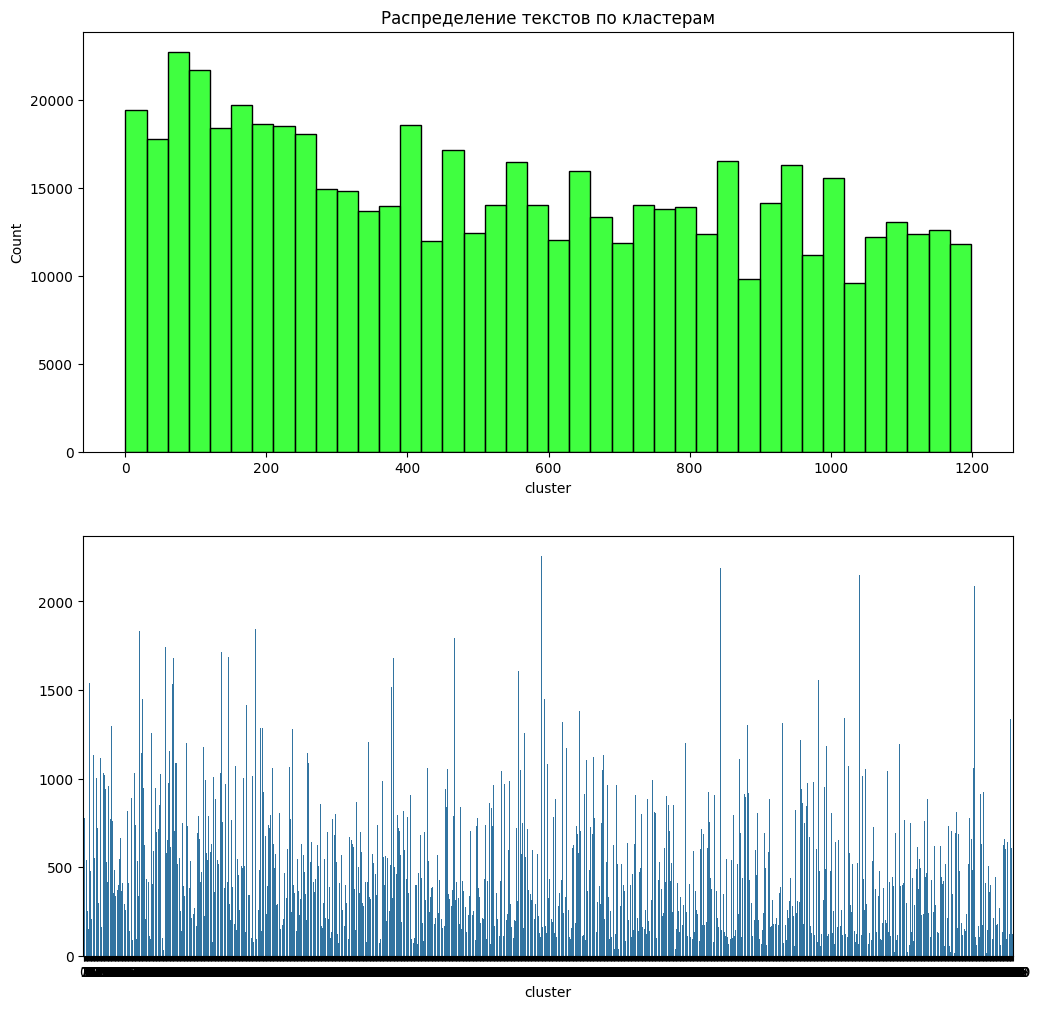

In [104]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
sns.barplot(x=cl_result.index, y=cl_result.values, ax=axes[1])
sns.histplot(df, x= df['cluster'], ax=axes[0],  bins=40, color='lime').set_title('Распределение текстов по кластерам')

In [58]:
print(f'Самый большой размер кластера: {max(cl_result.values)}')
print(f'Самый маленький размер кластера: {min(cl_result.values)}')
print(f'Средний размер кластера: {np.mean(cl_result.values)}')
print(f'Медианный размер кластера: {np.median(cl_result.values)}')
print(f'Самый распространенный размер кластера: {cl_result.value_counts().index[0]}')
print(f'Кластеров размером меньше 50: {len(cl_result[cl_result.values<50])}')

Самый большой размер кластера: 2258
Самый маленький размер кластера: 15
Средний размер кластера: 500.25166666666667
Медианный размер кластера: 409.0
Самый распространенный размер кластера: 260
Кластеров размером меньше 50: 18


С такими размерами кластера классификацию проводить нецелесообразно.

In [ ]:
y= df['cluster']
for m_key in MODELS:
    print(MODELS[m_key])
    X=norm_embeddings[m_key]
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=RANDOM_STATE)
    lr = LogisticRegression(C=0.5, max_iter=300, penalty='none', random_state=123,solver='saga', n_jobs=-1)
    lr.fit(X_train, y_train)
    print(lr.score(X_test, y_test))
    y_pred = lr.predict(X_test)
    f1_score_ml = f1_score(y_test, y_pred, average='weighted')
    print('f1_score=', f1_score_ml)
    print('accuracy=', accuracy_score(y_test, y_pred))
    classification_metrics = classification_report(y_test, y_pred, target_names=[ '0','1', '2'])
    print(classification_metrics)
    print('________________________')

In [48]:
filename=settings.get_fresh('FILENAME_REQUIREMENTS_LABELED')
files.save_dataframe(df, filename,MODEL_SUBDIR, to_compress=True)

'/mnt/docs/DataStorage/vkr/data/block_modeling/requirements_labeled.csv.gz'

# 5. Уточнение требований и навыков с помощью кластерного анализа

Координаты центра кластера

In [20]:
cluster_mean_u1, cluster_mean_u2, cluster_mean = cu.get_cluster_mean(df)
cluster_mean

array([10.318412, 10.105273], dtype=float32)

Выражения, содержащие названия навыков, найденные во всем датасете

In [21]:
unigrams_counter, bigrams_counter, trigrams_counter = cu.get_all_skills(requirements_dict)

In [22]:
unigrams_counter.most_common(10)

[('опыт', 603010),
 ('работа', 390838),
 ('знание', 366859),
 ('разработка', 177477),
 ('умение', 148831),
 ('понимание', 119477),
 ('система', 100933),
 ('год', 99912),
 ('1с', 85807),
 ('sql', 81472)]

In [23]:
bigrams_counter.most_common(10)

[('опыт работа', 291597),
 ('опыт разработка', 87827),
 ('умение работать', 42052),
 ('понимание принцип', 35214),
 ('английский язык', 32230),
 ('база данные', 25980),
 ('х год', 24639),
 ('уверенный знание', 24475),
 ('контроль версия', 22827),
 ('система контроль', 21815)]

In [24]:
trigrams_counter.most_common(10)

[('система контроль версия', 21494),
 ('опыт работа система', 16754),
 ('умение работать команда', 15091),
 ('3 х год', 13059),
 ('английский язык уровень', 12487),
 ('разбираться чужой код', 12148),
 ('контроль версия git', 11534),
 ('работа система контроль', 11490),
 ('знание английский язык', 11201),
 ('2 х год', 10708)]

Извлечение навыков, характерных для каждого кластера

In [25]:
cluster_indexes = df['cluster'].unique()
keywords, all_keywords = cu.get_cluster_skills(requirements_dict, df)

Начинается обработка кластера 348
Закончилась обработка кластера 348
Начинается обработка кластера 36
Закончилась обработка кластера 36
Начинается обработка кластера 457
Закончилась обработка кластера 457
Начинается обработка кластера 1060
Закончилась обработка кластера 1060
Начинается обработка кластера 878
Закончилась обработка кластера 878
Начинается обработка кластера 400
Закончилась обработка кластера 400
Начинается обработка кластера 891
Закончилась обработка кластера 891
Начинается обработка кластера 974
Закончилась обработка кластера 974
Начинается обработка кластера 772
Закончилась обработка кластера 772
Начинается обработка кластера 761
Закончилась обработка кластера 761
Начинается обработка кластера 1135
Закончилась обработка кластера 1135
Начинается обработка кластера 874
Закончилась обработка кластера 874
Начинается обработка кластера 147
Закончилась обработка кластера 147
Начинается обработка кластера 393
Закончилась обработка кластера 393
Начинается обработка кластера 17

In [27]:
len(all_keywords)

75562

In [34]:
all_keywords.items()

dict_items([('confluence', 5), ('ui', 1242), ('commerce', 1), ('end', 3), ('r &', 39), ('product & dev', 1), ('team foundation server', 44), ('foundation server .', 1), ('simatic manager', 1), ('& dev team', 1), ('core', 148), ('greenplum', 57), ('teamlead', 4), ('product', 73), ('dev', 2), ('team lead', 135), ('team', 56), ('frontend', 426), ('svn', 360), ('stand', 2), ('ceo', 1), ('pl', 234), ('slack', 1), ('back', 1), ('pm', 1), ('cvs', 53), ('cpo', 1), ('callcenter', 1), ('leader', 1), ('ajile', 1), ('talent', 1), ('management', 1), ('foundation', 97), ('server', 590), ('c++', 1545), ('lead', 4), ('vss', 1), ('simatic', 1), ('manager', 71), ('top', 39), ('production', 53), ('взаимодействие команда', 32), ('взаимодействие', 833), ('команда', 6062), ('управление команда', 419), ('управление', 3956), ('командный', 648), ('группа', 163), ('процесс', 3023), ('sqlalchemy', 63), ('sql set based', 1), ('set based processing', 1), ('set', 1), ('based', 1), ('processing', 22), ('presto sql e

In [37]:
df1=pd.DataFrame(all_keywords.items())
filename=settings.get_fresh('FILENAME_ALL_KEYWORD')
files.save_dataframe(df1, filename,READY_DATA_LOCAL_SUBDIR, to_compress=False)

'/mnt/docs/DataStorage/vkr/data/ready/all_keywords.csv'

In [38]:
filename=settings.get_fresh('FILENAME_CLUSTER_KEYWORDS')
files.save_data_dump(keywords, filename,READY_DATA_LOCAL_SUBDIR)

'/mnt/docs/DataStorage/vkr/data/ready/cluster_keywords.dmp'

In [39]:
keywords_list = cu.get_cluster_labels(selected_model, keywords, df)

Начинается обработка кластера 348
Закончилась обработка кластера 348
Начинается обработка кластера 36
Закончилась обработка кластера 36
Начинается обработка кластера 457
Закончилась обработка кластера 457
Начинается обработка кластера 1060
Закончилась обработка кластера 1060
Начинается обработка кластера 878
Закончилась обработка кластера 878
Начинается обработка кластера 400
Закончилась обработка кластера 400
Начинается обработка кластера 891
Закончилась обработка кластера 891
Начинается обработка кластера 974
Закончилась обработка кластера 974
Начинается обработка кластера 772
Закончилась обработка кластера 772
Начинается обработка кластера 761
Закончилась обработка кластера 761
Начинается обработка кластера 1135
Закончилась обработка кластера 1135
Начинается обработка кластера 874
Закончилась обработка кластера 874
Начинается обработка кластера 147
Закончилась обработка кластера 147
Начинается обработка кластера 393
Закончилась обработка кластера 393
Начинается обработка кластера 17

In [41]:
keywords_list

[{'cluster_id': 348,
  'mean_u1': 10.318412,
  'mean_u2': 10.105273,
  'key_0': ('команда', 393),
  'count_0': 0,
  'distance_0': 13.348891,
  'u1_0': array([2.3325858, 3.2304375], dtype=float32),
  'u2_0': array([2.1395142, 9.593678 ], dtype=float32),
  'key_1': ('командный', 110),
  'count_1': 0,
  'distance_1': 13.391975,
  'u1_1': array([2.2691298, 3.240946 ], dtype=float32),
  'u2_1': array([2.13617 , 9.408129], dtype=float32),
  'key_2': ('управление', 86),
  'count_2': 0,
  'distance_2': 15.457741,
  'u1_2': array([0.32497087, 7.091597  ], dtype=float32),
  'u2_2': array([-1.0069125, 11.419687 ], dtype=float32),
  'key_3': ('управление команда', 53),
  'count_3': 0,
  'distance_3': 15.537863,
  'u1_3': array([2.319513 , 3.3246343], dtype=float32),
  'u2_3': array([-1.0709684, 11.427303 ], dtype=float32),
  'key_4': ('процесс', 51),
  'count_4': 0,
  'distance_4': 15.8396845,
  'u1_4': array([-0.4815814,  8.614255 ], dtype=float32),
  'u2_4': array([-1.0952935, 11.431899 ], dtype

In [42]:
df1=pd.DataFrame(keywords_list)
filename=settings.get_fresh('FILENAME_CLUSTER_DATA')
files.save_dataframe(df1, filename,READY_DATA_LOCAL_SUBDIR, to_compress=False)

'/mnt/docs/DataStorage/vkr/data/ready/cluster_data.csv'